In [1]:
import numpy as np
import matplotlib.pyplot as plt
import control as ct
from numpy import array
from scipy.signal import chirp, lsim
import numpy.linalg as la
import scienceplots

np.set_printoptions(precision=3, suppress=True)

plt.style.use([
    'grid',
    'retro'
])
#plt.rcParams['lines.linewidth'] = 3
#plt.rcParams['font.size'] = 20

In [2]:
m  = 840  # kg
ix = 820  # kg*meter**2
iy = 1100 # kg*meter**2
mf = 53   # kg
mr = 76   # kg

M = np.diag([m, ix, iy, mf, mf, mr, mr])

a1 = 1.4  # meter
a2 = 1.47 # meter
b1 = 0.7  # meter
b2 = 0.75 # meter

# # # # # # # # # # # # 

kf  = 1e4   # N/meter
kr  = 1.3e4 # N/meter
ktf = 2e5   # N/meter
ktr = 2e5   # N/meter
kR  = 1e4   # (N*meter/rad)
w   = b1+b2    

k11 = 2*kf+2*kr
k21 = (b1-b2)*kf+(b2-b1)*kr
k31 = 2*(a2*kr-a1*kf)

k22 = kR + (b1**2+b2**2)*kf+(b1**2+b2**2)*kr
k32 = (a1*b2-a1*b1)*kf+(a2*b2-a2*b1)*kr
k42 = -b1*kf - (1/w)*kR
k52 = b2*kf+(1/2)*kR
k33 = 2*kf*a1**2+2*kr*a2**2
k44 = kf+ktf+(1/(w**2))*kR
k55 = kf+ktf+(1/(w**2))*kR

K = np.array([
    [k11,  k21,    k31,      -kf,      -kf,    -kr,    -kr],
    [k21,  k22,    k32,      k42,      k52,  b1*kr, -b2*kr],
    [k31,  k32,    k33,    a1*kf,    a1*kf, -a2*kr, -a2*kr],
    [-kf,  k42,  a1*kf,      k44, -kR/w**2,      0,      0],
    [-kf,  k52,  a1*kf, -kR/w**w,      k55,      0,      0],
    [-kr, b1*kr, -a2*kr,       0,        0, kr+ktr,      0],
    [-kr,-b2*kr, -a2*kr,       0,        0,      0, kr+ktr]
])

# # # # # # # # # # # # 

cf = 500 # N*s/meter
cr = 500 # N*s/meter

c11 = 2*cf+2*cr
c21 = (b1-b2)*cf+(b2-b1)*cr
c31 = 2*a2*cr-2*a1*cf
c22 = (b1**2+b2**2)*cf+(b1**2+b2**2)*cr
c32 = (a1*b2-a1*b1)*cf+(a2*b2-a2*b1)*cr
c33 = 2*cf*a1**2+2*cr*a2**2

C = np.array([
    [c11,   c21,   c31,    -cf,   -cf,   -cr,    -cr],
    [c21,   c22,   c32, -b1*cf, b2*cf, b1*cr, -b2*cr],
    [c31,   c32,   c33,  a1*cf, a1*cf,-a2*cr, -a2*cr],
    [-cf,-b1*cf, a1*cf,     cf,     0,     0,      0],
    [-cf, b2*cf, a1*cf,      0,    cf,     0,      0],
    [-cr, b1*cr,-a2*cr,      0,     0,    cr,      0],
    [-cr,-b2*cr, -a2*cr,     0,     0,     0,     cr]
])

F = np.array([
    [0, 0, 0, ktf, ktf, ktr, ktr]
]).T

X0 = array([0.1, 0, 0, 0.2, 0.2, 0.2, 0.2]).T

V0 = array([0, 0, 0, 0, 0, 0, 0]).T

N = M.shape[0]

In [3]:
F.T

array([[     0.,      0.,      0., 200000., 200000., 200000., 200000.]])

In [4]:
Z = np.zeros((N,N))
I = np.eye(N)

A = np.vstack([np.hstack([Z, I]), np.hstack([la.solve(-M, K), la.solve(-M, C)])])

B2 = I
B = np.vstack([Z, la.solve(M, B2)])

# y = Cx + Du
# Observation matrices
Cd = I
Cv = Z
Ca = Z

C = np.hstack((Cd - Ca @ la.solve(M, K), Cv - Ca @ la.solve(M, C)))
D = Ca @ la.solve(M, B2)

sys = ct.ss(A, B, C, D)
tf = ct.ss2tf(sys)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


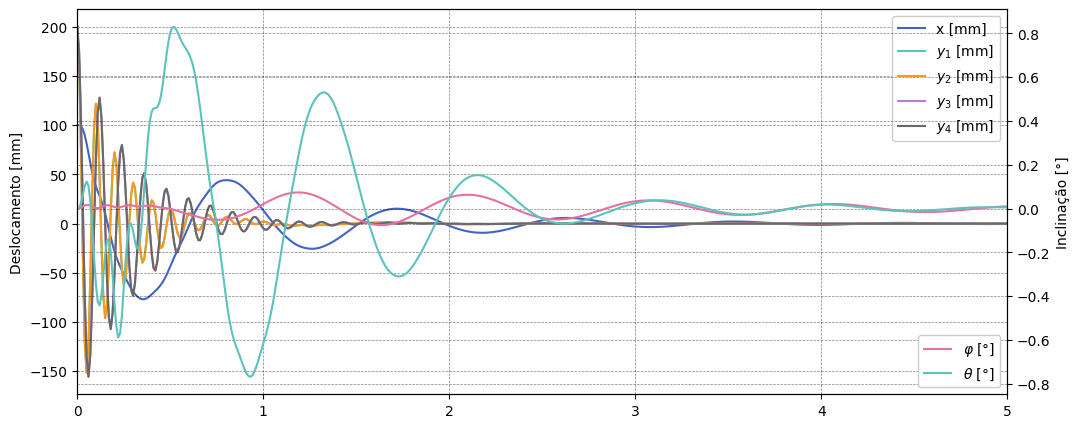

In [20]:
sampling_period = 1e-2
samples = 1000*6
duration = samples*sampling_period

t = np.arange(0, samples*sampling_period, sampling_period)
n = t.shape[0]

U = np.zeros((N, n))

t,y = ct.forced_response(sys, t, U)

t, y = ct.forced_response(sys, T=t, U=U, X0=np.block([X0.T, V0.T]))

plt.rcParams['figure.figsize'] = (12, 5)
fig, ax1 = plt.subplots(1, 1, sharex=True)
ax2 = ax1.twinx()

labels = ['x [mm]', '$\\varphi$ [°]', '$\\theta$ [°]', '$y_1$ [mm]', '$y_2$ [mm]', '$y_3$ [mm]', '$y_4$ [mm]']

colors = ['C6', 'C1', 'C2', 'C8', 'C4', 'C5', 'C3']

for i in range(N):
    if((i==1)or(i==2)):
        ax2.plot(t, np.degrees(y[i, :]), label=labels[i], color=colors[i])
    else:
        ax1.plot(t, (y[i, :]*1e3), label=labels[i], color=colors[i])
ax1.set_ylabel('Deslocamento [mm]')
ax2.set_ylabel('Inclinação [°]')
ax1.set_xlim(0, 5)
ax1.legend(loc='upper right')
ax2.legend(loc='lower right')

plt.xlabel('Tempo [s]')
plt.savefig('curves/damped_response.eps', dpi=600, transparent=True, bbox_inches='tight')
